In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div style="max-width:800px;margin:2rem auto;background:#ffffff;border-radius:1rem;box-shadow:0 4px 15px rgba(0,0,0,0.1);padding:2rem;font-family:'Segoe UI',sans-serif;">
  <h1 style="font-size:2rem;color:#2c3e50;text-align:center;margin-bottom:1rem;">
    Playground Series S5E6: Fertilizer Prediction
  </h1>
  <p style="font-size:1rem;color:#4a4a4a;line-height:1.5;margin-bottom:1.5rem;">
    In this notebook, we tackle the Playground Series S5E6 competition focused on predicting the optimal fertilizer type for various soil samples. We combine the provided train and test datasets with an external fertilizer dataset to enrich our training data and remove duplicates. Categorical features are encoded numerically, and mutual information analysis helps us identify the most relevant predictors. We then optimize an XGBoost classifier using Optuna, leveraging early stopping and pruning for efficient hyperparameter search. Model performance is validated via repeated stratified K-fold cross-validation, computing MAP@3 and log loss metrics. Finally, we prepare a top-3 submission aligned with competition requirements.
  </p>
  
  <div style="background:#f8f9fa; border-left:4px solid #2575fc; padding:1rem; margin:1.5rem 0; border-radius:0 8px 8px 0;">
    <p style="font-size:0.95rem; color:#4a4a4a; margin:0; line-height:1.5;">
      For detailed Exploratory Data Analysis (EDA) including feature distributions, correlations, and visualizations, visit my other notebook
      <a href="https://www.kaggle.com/code/chikonzeroselemani/ps-s5e6-eda" 
         target="_blank" 
         style="color:#2575fc; text-decoration:none; font-weight:600;"
         onmouseover="this.style.textDecoration='underline'" 
         onmouseout="this.style.textDecoration='none'">
        📊 PS-S5E6-Exploratory Data Analysis (EDA)
      </a>.
    </p>
  </div>
</div>

<a id="importing-libraries-section"></a>
<div style="
  display: inline-block;
  margin: 2rem auto;
  background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
  padding: 1rem 2rem;
  border-radius: 1rem;
  border: 2px solid rgba(255, 255, 255, 0.5);
  box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
  text-align: center;
">
  <h1 style="
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    font-size: 1.8rem;
    font-weight: 700;
    color: #ffffff;
    margin: 0;
    text-transform: uppercase;
    letter-spacing: 1px;
  ">
    Importing Libraries
  </h1>
</div>



In [2]:
# !pip install optuna-integration[xgboost]
# from optuna.integration import XGBoostPruningCallback
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import log_loss
from sklearn.base import clone
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")

<div style="
  display: flex;
  justify-content: center;
  margin: 2rem 0;
">
  <div style="
    background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
    padding: 0.75rem 1.5rem;
    border-radius: 1rem;
    border: 2px solid rgba(255, 255, 255, 0.5);
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
    text-align: center;
  ">
    <h1 style="
      font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
      font-size: 1.6rem;
      font-weight: 700;
      color: #ffffff;
      margin: 0;
      text-transform: uppercase;
      letter-spacing: 1px;
    ">
      Data Loading Overview
    </h1>
  </div>
</div>

<p style="font-style: italic; font-size: 1rem;">
  The data sources for training and testing are imported and then merged with external records for comprehensive coverage. Duplicate entries are removed to ensure a clean dataset for downstream analysis.
</p>


In [3]:
test_path = "/kaggle/input/playground-series-s5e6/test.csv"
train_path = "/kaggle/input/playground-series-s5e6/train.csv"
external_data_path = "/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv"

train = pd.read_csv(train_path, index_col="id")
test = pd.read_csv(test_path, index_col="id")
external = pd.read_csv(external_data_path)

overall_train = pd.concat([train,external], ignore_index=True)
overall_train = overall_train.drop_duplicates()

overall_train

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP
...,...,...,...,...,...,...,...,...,...
849995,32,71,61,Black,Tobacco,23,1,25,20-20
849996,35,72,47,Loamy,Millets,38,1,32,17-17-17
849997,28,50,61,Sandy,Maize,10,11,14,14-35-14
849998,29,57,63,Loamy,Ground Nuts,7,10,4,DAP


<div style="
  display: flex;
  justify-content: center;
  margin: 2rem 0;
">
  <div style="
    background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
    padding: 0.75rem 1.5rem;
    border-radius: 1rem;
    border: 2px solid rgba(255, 255, 255, 0.5);
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
    text-align: center;
  ">
    <h1 style="
      font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
      font-size: 1.6rem;
      font-weight: 700;
      color: #ffffff;
      margin: 0;
      text-transform: uppercase;
      letter-spacing: 1px;
    ">
      Label Encoding &amp; Split
    </h1>
  </div>
</div>

<p style="font-style: italic; font-size: 1rem;">
  Categorical features and the target variable are transformed into numerical labels to prepare for modeling. The same encoder is applied to both training and test sets to maintain consistency.
</p>



In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

x = overall_train.drop(columns=["Fertilizer Name"])
y = overall_train["Fertilizer Name"]

encoder = LabelEncoder()
targetEncoder = LabelEncoder()

categorical = x.select_dtypes(include=['object']).columns

y = targetEncoder.fit_transform(y)
for cat in categorical:
    x[cat] = encoder.fit_transform(x[cat])
    test[cat] = encoder.transform(test[cat])


In [5]:
x

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,37,70,36,1,8,36,4,5
1,27,69,65,4,4,30,6,18
2,29,63,32,4,4,24,12,16
3,35,62,54,4,0,39,12,4
4,35,58,43,3,6,37,2,16
...,...,...,...,...,...,...,...,...
849995,32,71,61,0,9,23,1,25
849996,35,72,47,2,4,38,1,32
849997,28,50,61,4,3,10,11,14
849998,29,57,63,2,2,7,10,4


<div style="
  display: flex;
  justify-content: center;
  margin: 2rem 0;
">
  <div style="
    background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
    padding: 0.5rem 1rem;
    border-radius: 0.75rem;
    border: 2px solid rgba(255, 255, 255, 0.5);
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
    text-align: center;
  ">
    <h1 style="
      font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
      font-size: 1.4rem;
      font-weight: 700;
      color: #ffffff;
      margin: 0;
      text-transform: uppercase;
      letter-spacing: 1px;
    ">
      Mutual Information Analysis
    </h1>
  </div>
</div>

<p style="font-style: italic; font-size: 1rem;">
  Evaluate each feature’s relevance by computing mutual information scores with the target. Results are displayed in a table and visualized in a bar chart for easy interpretation.
</p>




,feature,mi_score
0,Soil Type,0.011247
1,Humidity,0.008027
2,Temparature,0.007841
3,Crop Type,0.007767
4,Nitrogen,0.007719
5,Potassium,0.007347
6,Phosphorous,0.007125
7,Moisture,0.006615


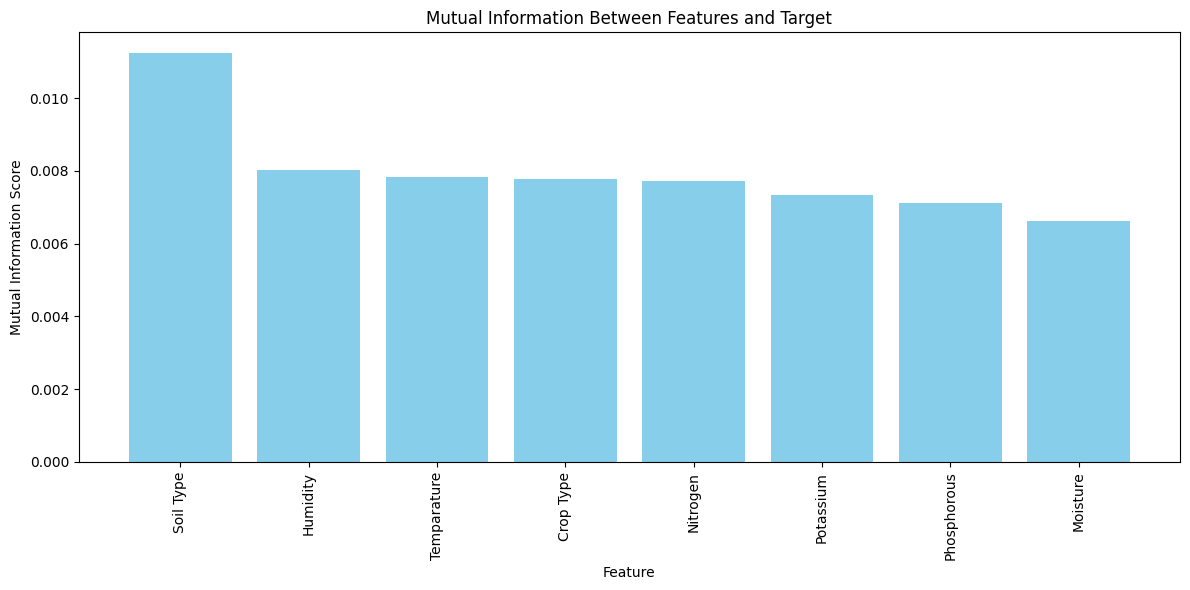

In [6]:
# Compute mutual information between each feature and the target
mi_scores = mutual_info_classif(x, y, discrete_features='auto', random_state=42)
    
    # Create a DataFrame of features and their MI scores
mi_df = pd.DataFrame({
        "feature": x.columns,
        "mi_score": mi_scores
    }).sort_values(by="mi_score", ascending=False).reset_index(drop=True)
    
    # Display the MI scores
display(mi_df)
    
    # Plot MI scores as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(mi_df["feature"], mi_df["mi_score"], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Between Features and Target")
plt.tight_layout()
plt.show()


<div style="
  display: flex;
  justify-content: center;
  margin: 1.5rem 0;
">
  <div style="
    background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
    padding: 0.5rem 1rem;
    border-radius: 0.75rem;
    border: 2px solid rgba(255, 255, 255, 0.5);
    text-align: center;
  ">
    <h1 style="
      font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
      font-size: 1.4rem;
      font-weight: 700;
      color: #ffffff;
      margin: 0;
      text-transform: uppercase;
      letter-spacing: 1px;
    ">
      Mean Average Precision @ 3
    </h1>
  </div>
</div>

<p style="font-style: italic; font-size: 0.95rem;">
  This function computes the mean average precision at cutoff 3 by checking if the true label appears in the top 3 predicted probabilities. It assigns higher weight to correctly predicted labels that rank higher, averaging the reciprocal ranks over all samples.
</p>


In [7]:
def map_at_3(y_true, y_pred_proba, k=3):

    map_score = 0.0
    y_true = y_true.values if isinstance(y_true, pd.Series) else y_true  # Convert Series to NumPy array
    for i in range(len(y_true)):
        top_k_preds = np.argsort(y_pred_proba[i])[-k:][::-1]  # Get top k predictions
        if y_true[i] in top_k_preds:
            rank = np.where(top_k_preds == y_true[i])[0][0] + 1
            map_score += 1.0 / rank
    return map_score / len(y_true)

<div style="
  display: flex;
  justify-content: center;
  margin: 2rem 0;
">
  <div style="
    background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
    padding: 0.5rem 1rem;
    border-radius: 0.75rem;
    border: 2px solid rgba(255, 255, 255, 0.5);
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
    text-align: center;
  ">
    <h1 style="
      font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
      font-size: 1.4rem;
      font-weight: 700;
      color: #ffffff;
      margin: 0;
      text-transform: uppercase;
      letter-spacing: 1px;
    ">
      Hyperparameter Optimization
    </h1>
  </div>
</div>

<p style="font-style: italic; font-size: 1rem;">
  We split the data into stratified training and validation sets to preserve class balance. A custom Optuna objective tunes XGBoost hyperparameters by maximizing MAP@3 on the holdout. Early stopping and pruning callbacks accelerate convergence and reduce wasted trials. The best model iteration is selected for final evaluation.
</p>



In [8]:
# Split data with stratification
X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2500),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-5, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100, log=True),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist",  # Faster and memory-efficient
        "enable_categorical": False,
        "early_stopping_rounds": None,
        "device" :"cuda"
    }
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-mlogloss")
    
    model = XGBClassifier(**params)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=50,
        verbose=0,
        callbacks=[pruning_callback]
    )

    # Get best iteration from early stopping
    best_iter = model.best_iteration
    if best_iter is None:
        best_iter = params["n_estimators"]
    
    # Predict using best model
    preds = model.predict_proba(X_val, iteration_range=(0, best_iter))
    return map_at_3(y_val, preds)

# # Create study with TPE sampler and pruning
# study = optuna.create_study(
#     direction="maximize",
#     sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=20),
#     pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
# )
# study.optimize(objective, n_trials=100, timeout=3600)  # 1 hour timeout

# print("Best trial:")
# trial = study.best_trial
# print(f"  Value (accuracy): {trial.value:.5f}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")


<div style="
  display: flex;
  justify-content: center;
  margin: 2rem 0;
">
  <div style="
    background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
    padding: 0.5rem 1rem;
    border-radius: 0.52rem;
    border: 2px solid rgba(255, 255, 255, 0.5);
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
    text-align: center;
  ">
    <h1 style="
      font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
      font-size: 1.4rem;
      font-weight: 700;
      color: #ffffff;
      margin: 0;
      text-transform: uppercase;
      letter-spacing: 1px;
    ">
      Reapeted Cross-Validation Setup
    </h1>
  </div>
</div>

<p style="font-style: italic; font-size: 1rem;">
  A repeated stratified K-fold scheme splits the data into 5 folds over 2 repeats to ensure balanced class representation. Out-of-fold predictions and test set averages are accumulated for each fold. The MAP@3 metric is computed per fold to assess model performance. Final test predictions are aggregated across all folds for robust inference.
</p>


In [9]:
# Cross-validation# Prepare data containers
n_classes=7
oof_proba = np.zeros((len(x), n_classes))
test_preds = np.zeros((len(test), n_classes))
fold_counter = np.zeros(len(x))


best_params = {
    'tree_method': 'hist',
    'n_estimators': 5000,
    'objective': 'multi:softprob',
    'random_state': 32,
    'enable_categorical': True,
    'verbosity': 0,
    'eval_metric': 'mlogloss',
    'booster': 'gbtree',
    "device": "cuda",
    'n_jobs': -1,
    'learning_rate': 0.1,
    'num_class': 7,
    'lambda': 0.05656209749983576,
    'alpha': 5.620898657099113,
    'colsample_bytree': 0.2587327850345624, 
    'subsample': 0.8276149323901826,
    'max_depth': 20,
    'min_child_weight': 10
    }


n_splits = 5
n_repeats = 2
seed = 42

cv = RepeatedStratifiedKFold(
    n_splits=n_splits,
    n_repeats=n_repeats,
    random_state=seed
)

print(f"Starting {n_splits}-fold CV with {n_repeats} repeats")
fold_scores = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(x, y)):
    print(f"\n=== Fold {fold+1}/{n_splits * n_repeats} ===")
    
    X_train, X_valid = x.iloc[train_idx], x.iloc[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Initialize model
    model = XGBClassifier(**best_params)
    model.fit(
        X_train, 
        y_train,
        early_stopping_rounds=50,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
    
    # Get validation predictions
    valid_proba = model.predict_proba(X_valid)
    oof_proba[valid_idx] += valid_proba
    fold_counter[valid_idx] += 1
    
    # Calculate MAP@3 for this fold
    fold_map = map_at_3(y_valid, valid_proba)
    fold_scores.append(fold_map)
    print(f"Fold {fold+1} MAP@3: {fold_map:.5f}")
    
    # Predict test set
    test_preds += model.predict_proba(test) / (n_splits * n_repeats)


Starting 5-fold CV with 2 repeats

=== Fold 1/10 ===
Fold 1 MAP@3: 0.36703

=== Fold 2/10 ===
Fold 2 MAP@3: 0.36675

=== Fold 3/10 ===
Fold 3 MAP@3: 0.36574

=== Fold 4/10 ===
Fold 4 MAP@3: 0.36551

=== Fold 5/10 ===
Fold 5 MAP@3: 0.36508

=== Fold 6/10 ===
Fold 6 MAP@3: 0.36668

=== Fold 7/10 ===
Fold 7 MAP@3: 0.36604

=== Fold 8/10 ===
Fold 8 MAP@3: 0.36544

=== Fold 9/10 ===
Fold 9 MAP@3: 0.36708

=== Fold 10/10 ===
Fold 10 MAP@3: 0.36663


<div style="
  display: flex;
  justify-content: center;
  margin: 2rem 0;
">
  <div style="
    background: linear-gradient(135deg, #6a11cb 0%, #2575fc 100%);
    padding: 0.5rem 1rem;
    border-radius: 0.75rem;
    border: 2px solid rgba(255, 255, 255, 0.5);
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
    text-align: center;
  ">
    <h1 style="
      font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
      font-size: 1.4rem;
      font-weight: 700;
      color: #ffffff;
      margin: 0;
      text-transform: uppercase;
      letter-spacing: 1px;
    ">
      Finalize OOF Predictions
    </h1>
  </div>
</div>

<p style="font-style: italic; font-size: 1rem;">
  Out-of-fold probabilities are normalized by the fold counts to produce unbiased estimates for every sample. Aggregate cross-validation metrics including MAP@3 and log loss provide a summary of model performance. Top-3 test predictions are decoded back to original labels and formatted per submission requirements. The final CSV file is generated and ready for upload.
</p>


In [10]:
# Finalize OOF predictions
oof_proba /= fold_counter[:, np.newaxis]

# Calculate overall metrics
cv_map = np.mean(fold_scores)
oof_logloss = log_loss(y, oof_proba)

print("\n" + "=" * 50)
print(f"CV MAP@3: {cv_map:.5f}")
print(f"OOF Log Loss: {oof_logloss:.5f}")
print(f"Individual Fold MAP@3 Scores: {[f'{s:.5f}' for s in fold_scores]}")

# Generate submission
top3_indices = np.argsort(-test_preds, axis=1)[:, :3]  # Get top 3 predictions
top3_labels = targetEncoder.inverse_transform(top3_indices.ravel())
top3_labels = top3_labels.reshape(len(test), 3)

id = pd.read_csv(test_path)["id"]

submission = pd.DataFrame({
    "id": id,
    "Fertilizer Name": [" ".join(row) for row in top3_labels]
})
submission.to_csv("submission.csv", index=False)
print("\n✔ Submission file created: submission.csv")
submission.head()


CV MAP@3: 0.36620
OOF Log Loss: 1.88787
Individual Fold MAP@3 Scores: ['0.36703', '0.36675', '0.36574', '0.36551', '0.36508', '0.36668', '0.36604', '0.36544', '0.36708', '0.36663']

✔ Submission file created: submission.csv


,id,Fertilizer Name
0,750000,10-26-26 20-20 DAP
1,750001,17-17-17 10-26-26 28-28
2,750002,20-20 Urea 28-28
3,750003,14-35-14 10-26-26 DAP
4,750004,20-20 Urea 28-28


<div style="max-width:800px; margin:2.5rem auto; background:#f0f7ff; border-radius:14px; padding:2rem; border:1px solid #d0e3ff; font-family:'Segoe UI',sans-serif; box-shadow:0 4px 12px rgba(0,0,0,0.08);">
  <div style="display:flex; align-items:center; gap:1.2rem; margin-bottom:1.5rem;">
    <span style="font-size:2rem;">👍</span>
    <h3 style="margin:0; font-size:1.5rem; color:#2c3e50; font-weight:700;">Found This Notebook Helpful?</h3>
  </div>
  
  <p style="font-size:1.1rem; color:#4a4a4a; margin-bottom:1.75rem; line-height:1.6;">
    🚀 If this notebook contributed to your understanding or helped with your competition submission, 
    please consider giving an upvote ⬆️! Your support motivates me to create more high-quality content.
  </p>
  

  
  <p style="font-size:1rem; color:#6c757d; margin-top:1.5rem; margin-bottom:0; line-height:1.6;">
    📊 For deeper insights, check out my comprehensive <a href="https://www.kaggle.com/code/chikonzeroselemani/ps-s5e6-eda" target="_blank" style="color:#2575fc; text-decoration:none; font-weight:600;">Exploratory Data Analysis notebook</a> 
    featuring detailed visualizations and in-depth feature analysis.
  </p>
</div>